# Pemberian Label Mobil Dengan K MEANS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
import time
import os

# Mengabaikan pesan warning
warnings.filterwarnings('ignore')

In [3]:
file_path = 'Dataset/CarsDataset2025.csv' 

try:
    df = pd.read_csv(file_path, encoding='latin-1')
    print(f"Data dimuat: {df.shape[0]} baris, {df.shape[1]} kolom.")
    display(df[['Company Names', 'Cars Names', 'Cars Prices', 'Seats']].head())
except FileNotFoundError:
    print("File tidak ditemukan. Cek path file kembali.")

Data dimuat: 1218 baris, 11 kolom.


,Company Names,Cars Names,Cars Prices,Seats
0,FERRARI,SF90 STRADALE,"$1,100,000",2
1,ROLLS ROYCE,PHANTOM,"$460,000",5
2,Ford,KA+,"$12,000-$15,000",5
3,MERCEDES,GT 63 S,"$161,000",4
4,AUDI,AUDI R8 Gt,"$253,290",2


In [4]:
if df is not None:
    # Gabung Nama
    df['Company Names'] = df['Company Names'].astype(str)
    df['Cars Names'] = df['Cars Names'].astype(str)
    df['Car_Full_Name'] = df['Company Names'] + " " + df['Cars Names']
    
    # Fungsi Bersih Harga
    def clean_price(price_str):
        if pd.isna(price_str): return None
        clean_str = str(price_str).replace('$', '').replace(',', '').replace(' ', '')
        if '-' in clean_str:
            try:
                parts = clean_str.split('-')
                return (float(parts[0]) + float(parts[1])) / 2
            except:
                return None
        try:
            return float(clean_str)
        except:
            return None

    # Terapkan Cleaning
    df['Price_Cleaned'] = df['Cars Prices'].apply(clean_price)
    df['Seats_Cleaned'] = pd.to_numeric(df['Seats'], errors='coerce')

    # Hapus NaN
    df_clean = df.dropna(subset=['Price_Cleaned', 'Seats_Cleaned']).reset_index(drop=True)
    
    print(f"Data bersih: {len(df_clean)} baris.")
    display(df_clean[['Car_Full_Name', 'Price_Cleaned', 'Seats_Cleaned']].head())

Data bersih: 1200 baris.


,Car_Full_Name,Price_Cleaned,Seats_Cleaned
0,FERRARI SF90 STRADALE,1100000.0,2.0
1,ROLLS ROYCE PHANTOM,460000.0,5.0
2,Ford KA+,13500.0,5.0
3,MERCEDES GT 63 S,161000.0,4.0
4,AUDI AUDI R8 Gt,253290.0,2.0


In [5]:
# Fitur yang dipakai
X = df_clean[['Price_Cleaned', 'Seats_Cleaned']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Preview data setelah diskalakan
df_scaled_preview = pd.DataFrame(X_scaled, columns=['Price_Scaled', 'Seats_Scaled'])
print("Data berhasil dinormalisasi (Z-Score).")
display(df_scaled_preview.head())

Data berhasil dinormalisasi (Z-Score).


,Price_Scaled,Seats_Scaled
0,1.343128,-1.900769
1,0.448876,0.093626
2,-0.175004,0.093626
3,0.031093,-0.571172
4,0.160047,-1.900769


Mencari jumlah cluster (K) optimal menggunakan Elbow Method...


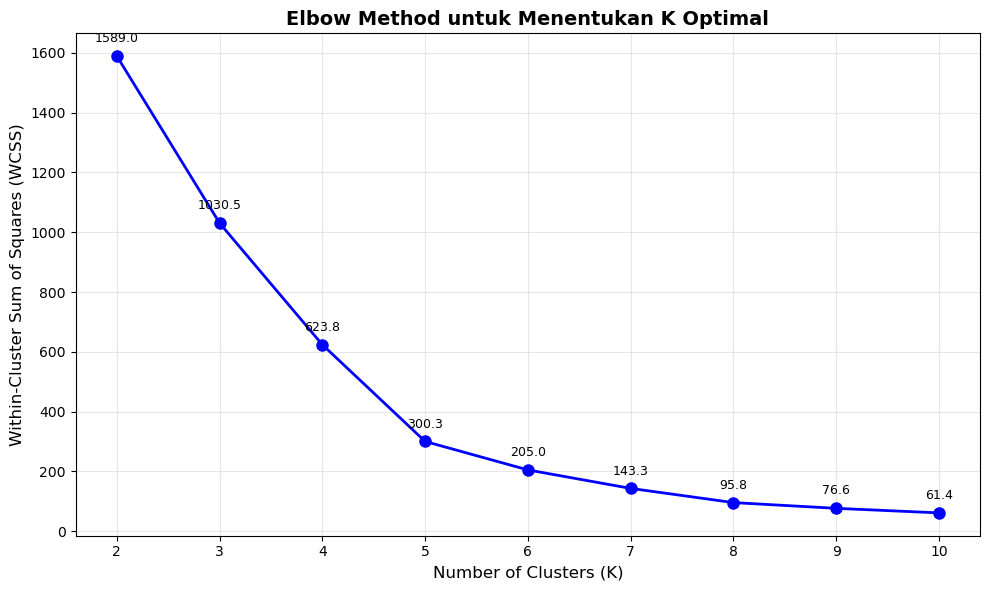


Nilai WCSS (Within-Cluster Sum of Squares) untuk setiap K:


,K,WCSS,Penurunan WCSS
0,2,1588.99,-
1,3,1030.52,558.48
2,4,623.81,406.71
3,5,300.31,323.49
4,6,205.04,95.27
5,7,143.27,61.77
6,8,95.79,47.48
7,9,76.58,19.20
8,10,61.35,15.23



Rekomendasi K berdasarkan Elbow Method: 6
- Pada K = 6, terjadi perlambatan signifikan dalam penurunan WCSS


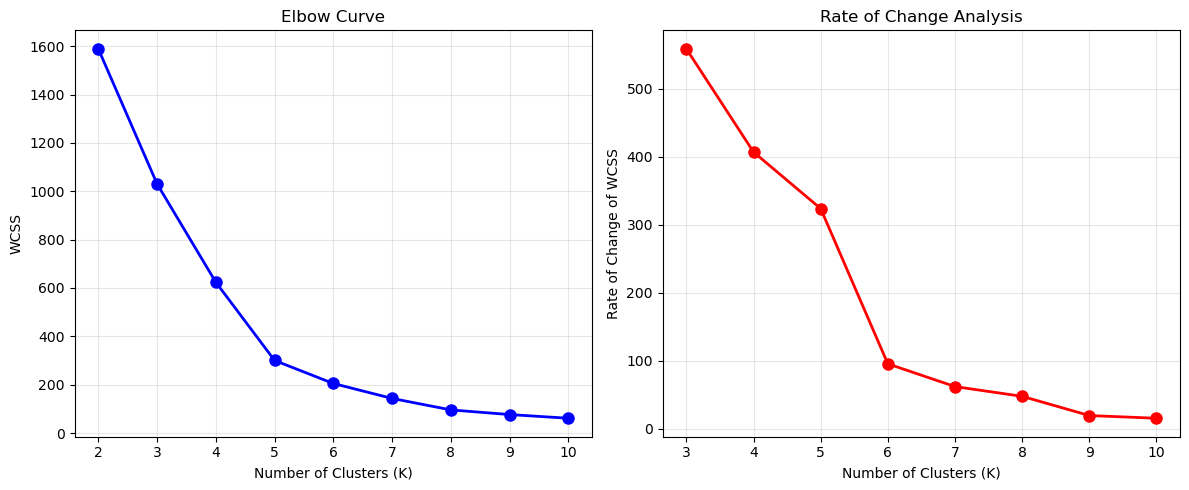


INTERPRETASI ELBOW METHOD:
- Pilih K dimana penambahan cluster tidak lagi memberikan
  penurunan WCSS yang signifikan (titik siku/elbow)
- WCSS yang lebih rendah menunjukkan clustering yang lebih baik
- Balance antara jumlah cluster dan kompleksitas model


In [7]:
print("Mencari jumlah cluster (K) optimal menggunakan Elbow Method...")

# Range nilai K yang akan diuji
k_range = range(2, 11)  # Menguji K dari 2 sampai 10

# Menyimpan nilai inersia (WCSS) untuk setiap K
inertia_values = []

# Menghitung inersia untuk setiap nilai K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

# Membuat plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.title('Elbow Method untuk Menentukan K Optimal', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

# Menambahkan anotasi nilai inersia pada setiap titik
for i, (k, inertia) in enumerate(zip(k_range, inertia_values)):
    plt.annotate(f'{inertia:.1f}', 
                 (k, inertia), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontsize=9)

plt.tight_layout()
plt.show()

# Menampilkan nilai inersia dalam bentuk tabel
print("\nNilai WCSS (Within-Cluster Sum of Squares) untuk setiap K:")
inertia_df = pd.DataFrame({
    'K': k_range,
    'WCSS': [f"{x:.2f}" for x in inertia_values],
    'Penurunan WCSS': ['-'] + [f"{(inertia_values[i-1] - inertia_values[i]):.2f}" 
                             for i in range(1, len(inertia_values))]
})
display(inertia_df)

# Menganalisis elbow point
# Metode: mencari titik dimana penurunan inersia mulai melambat
wcss_diff = [inertia_values[i-1] - inertia_values[i] for i in range(1, len(inertia_values))]
wcss_diff_diff = [wcss_diff[i-1] - wcss_diff[i] for i in range(1, len(wcss_diff))]

# Mencari elbow point (titik dimana penurunan kedua terbesar)
recommended_k = 3 # Default fallback jika kalkulasi gagal
if len(wcss_diff_diff) > 0:
    elbow_point = np.argmax(wcss_diff_diff) + 2  # +2 karena mulai dari K=2
    recommended_k = k_range[elbow_point]
    
    print(f"\nRekomendasi K berdasarkan Elbow Method: {recommended_k}")
    print(f"- Pada K = {recommended_k}, terjadi perlambatan signifikan dalam penurunan WCSS")
else:
    print("\nTidak dapat menentukan elbow point secara otomatis, menggunakan default K=3")

# Opsional: Visualisasi dengan metode derivative untuk melihat elbow point lebih jelas
plt.figure(figsize=(12, 5))

# Subplot 1: Elbow curve normal
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Curve')
plt.grid(True, alpha=0.3)

# Subplot 2: Rate of change of WCSS
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], wcss_diff, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Rate of Change of WCSS')
plt.title('Rate of Change Analysis')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("INTERPRETASI ELBOW METHOD:")
print("- Pilih K dimana penambahan cluster tidak lagi memberikan")
print("  penurunan WCSS yang signifikan (titik siku/elbow)")
print("- WCSS yang lebih rendah menunjukkan clustering yang lebih baik")
print("- Balance antara jumlah cluster dan kompleksitas model")
print("="*50)

=== Menjalankan K-Means (K=6) ===

=== HASIL EVALUASI ===
• Waktu Eksekusi   : 0.035136 detik
• Silhouette Score : 0.7908 (Makin tinggi makin bagus)
• Davies-Bouldin   : 0.3136 (Makin rendah makin bagus)


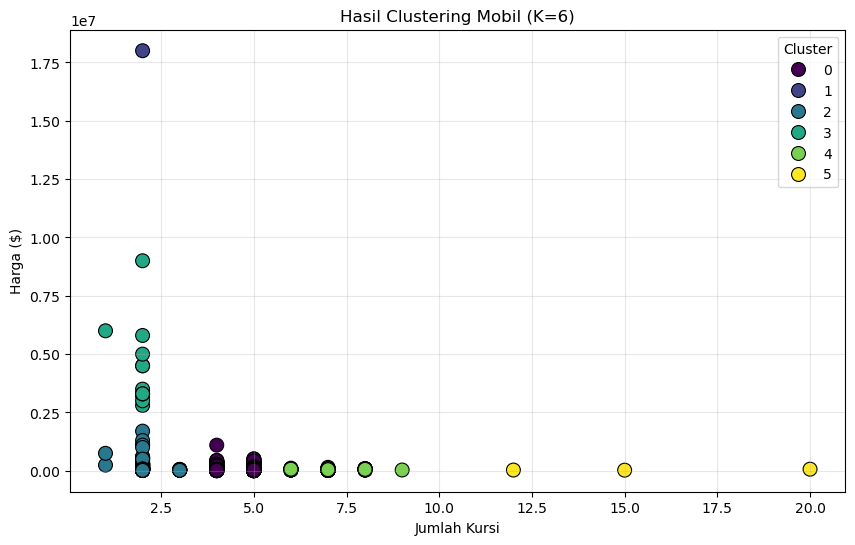


✅ File CSV berhasil disimpan di: Hasil\KMeans_Result_K6.csv
   (Berisi atribut asli + kolom 'cluster')


In [8]:
# Gunakan K dari rekomendasi di atas
k_final = recommended_k 

print(f"=== Menjalankan K-Means (K={k_final}) ===")

# 1. Mulai Timer
start_time = time.time()

# 2. Fit Model
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# 3. Stop Timer
end_time = time.time()
exec_time = end_time - start_time

# 4. Hitung Metrik Evaluasi
sil_score = silhouette_score(X_scaled, labels)
dbi_score = davies_bouldin_score(X_scaled, labels)

# Masukkan label ke dataframe
df_clean['cluster'] = labels

print("\n=== HASIL EVALUASI ===")
print(f"• Waktu Eksekusi   : {exec_time:.6f} detik")
print(f"• Silhouette Score : {sil_score:.4f} (Makin tinggi makin bagus)")
print(f"• Davies-Bouldin   : {dbi_score:.4f} (Makin rendah makin bagus)")

# 5. Visualisasi
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Seats_Cleaned', y='Price_Cleaned', 
                hue='cluster', palette='viridis', s=100, edgecolor='black')
plt.title(f'Hasil Clustering Mobil (K={k_final})')
plt.xlabel('Jumlah Kursi')
plt.ylabel('Harga ($)')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# 6. Export ke CSV
output_dir = 'Hasil'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Siapkan dataframe final (Hapus kolom bantuan cleaning jika tidak perlu, simpan yang penting)
df_export = df_clean.copy()
file_name = f'KMeans_Result_K{k_final}.csv'
csv_path = os.path.join(output_dir, file_name)

df_export.to_csv(csv_path, index=False)
print(f"\n✅ File CSV berhasil disimpan di: {csv_path}")
print(f"   (Berisi atribut asli + kolom 'cluster')")

# PROFIL HASIL CLUSTER

In [10]:
# Grouping berdasarkan cluster untuk melihat karakteristik
cluster_summary = df_clean.groupby('cluster')[['Price_Cleaned', 'Seats_Cleaned']].agg(['mean', 'min', 'max', 'count'])

# Format agar enak dibaca
pd.options.display.float_format = '{:,.2f}'.format
display(cluster_summary)

print("\nInterpretasi Singkat (Contoh Cara Membaca):")
for i in range(len(cluster_summary)):
    avg_price = cluster_summary.loc[i, ('Price_Cleaned', 'mean')]
    avg_seat = cluster_summary.loc[i, ('Seats_Cleaned', 'mean')]
    count = cluster_summary.loc[i, ('Price_Cleaned', 'count')]
    print(f"- Cluster {i}: Rata-rata Harga ${avg_price:,.0f}, Rata-rata Kursi {avg_seat:.1f} ({count} mobil)")

Price_Cleaned                                   Seats_Cleaned        \
                 mean           min           max count          mean   min   
cluster                                                                       
0           63,090.02      4,000.00  1,100,000.00   848          4.81  4.00   
1       18,000,000.00 18,000,000.00 18,000,000.00     1          2.00  2.00   
2          199,960.07     13,500.00  1,700,000.00   138          2.09  1.00   
3        4,400,000.00  2,800,000.00  9,000,000.00    13          1.92  1.00   
4           51,119.97     15,000.00    149,990.00   197          7.06  6.00   
5           43,666.67     28,000.00     70,000.00     3         15.67 12.00   

                     
          max count  
cluster              
0        5.00   848  
1        2.00     1  
2        3.00   138  
3        2.00    13  
4        9.00   197  
5       20.00     3


Interpretasi Singkat (Contoh Cara Membaca):
- Cluster 0: Rata-rata Harga $63,090, Rata-rata Kursi 4.8 (848 mobil)
- Cluster 1: Rata-rata Harga $18,000,000, Rata-rata Kursi 2.0 (1 mobil)
- Cluster 2: Rata-rata Harga $199,960, Rata-rata Kursi 2.1 (138 mobil)
- Cluster 3: Rata-rata Harga $4,400,000, Rata-rata Kursi 1.9 (13 mobil)
- Cluster 4: Rata-rata Harga $51,120, Rata-rata Kursi 7.1 (197 mobil)
- Cluster 5: Rata-rata Harga $43,667, Rata-rata Kursi 15.7 (3 mobil)
